# Project Topic

## Analysis of Diabetes Patient Readmissions

In this project, we analyze data collected from 130 US hospitals between 1999 and 2008 to predict whether a patient with diabetes will be readmitted within 30 days of discharge. The objective is formulated as a **supervised learning** problem, specifically a **binary classification problem**. The output should be an output of whether the patient will be readmitted early (<30 days) or not (<30 days).

### Importance of the Project

Readmission may indicate that a patient has not received enough attention or treatment. Since ~11% of patients in this dataset are readmitted early, predicting this risk may help hospitals identify high-risk individuals for targeted interventions. This, in turn, may reduce the risk of readmission or deterioration in patients, improving the quality of care by optimizing resource allocation.

## Data Description

### Dataset Source
The dataset is sourced from the UCI Machine Learning Repository (ID 296):  
Strack, B., DeShazo, J. P., Gennings, C., Olmo, J. L., Ventura, S., Cios, K. J., & Clore, J. N. (2014). 
"Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records." 
*BioMed Research International*, 2014, Article ID 781670.  
[Link](https://archive.ics.uci.edu/dataset/296).

### Dataset Overview
The dataset contains **101,766 rows** (patient records) and **50 columns** (47 features, 2 identifiers, and 1 target variable), 
representing 10 years (1999–2008) of clinical care data from 130 US hospitals. 
Each row corresponds to an inpatient encounter for a patient diagnosed with diabetes, 
with a hospital stay between 1 and 14 days, where laboratory tests and medications were administered. 
The target variable, `readmitted`, indicates whether the patient was readmitted (<30 days, >30 days, or No).

### Key Features
The dataset includes a mix of categorical and numeric features. Some examples are provided below:
- **encounter_id**: unique identifier for each hospital encounter (integer).
- **patient_nbr**: unique patient identifier (integer).
- **age**: patient age group (category: [0-10], [10-20], ..., [90-100)).
- **time_in_hospital**: days in hospital (integer, 1-14).
- **num_lab_procedures**: number of lab tests performed (integer).
- **num_medications**: number of medications prescribed (integer).
- **readmitted**: target variable (categorical: <30, >30, None).
Full details are in the [dataset documentation](https://archive.ics.uci.edu/dataset/296).  
Missing values are present (e.g., "?" in `weight`, `race`), requiring preprocessing.

### Data Size
- **Rows**: 101,766  
- **Columns**: 50 (47 features, 2 identifiers, 1 target)  
- **File Size**: ~20 MB (CSV format).


## Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand its structure, visualize key features, and identify issues such as missing values, outliers, and class imbalances that may impact modeling. The goal is to identify patterns, such as relationships between length of hospital stay or medication use and risk of readmission, to guide preprocessing and model selection.

In [1]:
# Import Libraries
# Standard data manipulation and visualization libraries
import pandas as pd                    # Data manipulation and analysis
import numpy as np                     # Numerical computations
import matplotlib.pyplot as plt        # Basic plotting
import seaborn as sns                  # Advanced statistical visualizations
import warnings                        # Suppress warnings for cleaner output

# Data loading
from ucimlrepo import fetch_ucirepo    # Fetch dataset from UCI repository

# Statistical analysis
from scipy.stats import ttest_ind      # T-test for comparing means

# Preprocessing and encoding
from sklearn.preprocessing import LabelEncoder      # Encode ordinal categorical features
from sklearn.preprocessing import StandardScaler    # Scale numeric features
from category_encoders import TargetEncoder         # Target encoding for high-cardinality features

# Model selection and resampling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  # Split data, CV, hyperparameter tuning
from imblearn.over_sampling import SMOTE              # Handle class imbalance

# Machine learning models
from sklearn.linear_model import LogisticRegression   # Baseline classification model
from sklearn.ensemble import RandomForestClassifier, VotingClassifier  # Tree-based ensemble model, ensemble voting
from xgboost import XGBClassifier                     # Gradient boosting model
from sklearn.neural_network import MLPClassifier      # Neural network model
from catboost import CatBoostClassifier               # CatBoost model
from lightgbm import LGBMClassifier                   # LightGBM model

# Evaluation metrics and visualization
from sklearn.metrics import (classification_report,   # Detailed classification metrics
                             roc_auc_score,           # ROC-AUC score
                             roc_curve,               # ROC curve data
                             precision_recall_curve,  # Precision-Recall curve data
                             auc,                     # Area under curve for PR-AUC
                             fbeta_score,             # F-beta score for recall-focused evaluation
                             confusion_matrix)        # Confusion matrix

### Data Loading

The dataset is loaded from the UCI Machine Learning Repository (ID 296) using the `ucimlrepo` library. We suppress warnings to avoid clutter from potential data type inconsistencies, which will be addressed during cleaning.

In [2]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296) 
    X = diabetes_130_us_hospitals_for_years_1999_2008.data.features 
    y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

### Data Loading Validation

After loading, we confirm that the dataset structure is as expected: 47 features in `X` and 1 target column (`readmitted`) in `y`. We also check the total number of missing values and unique target values to ensure data integrity before analysis.

In [3]:
print("Dataset Verification:")
print("=" * 50)
print(f"{'Features Shape':<20}: {X.shape[0]} rows, {X.shape[1]} columns")
print(f"{'Target Shape':<20}: {y.shape[0]} rows, {y.shape[1]} column")
print(f"{'Missing Values (X)':<20}: {X.isnull().sum().sum()} total")
print(f"{'Unique Targets (y)':<20}: {list(y['readmitted'].unique())}")

# Set display options for compact output
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 1000)

print("=" * 50)
print("\nFirst 5 Rows of Features (X):")
print(X.head())

print("\nFirst 5 Rows of Target (y):")
print(y.head())


Dataset Verification:
Features Shape      : 101766 rows, 47 columns
Target Shape        : 101766 rows, 1 column
Missing Values (X)  : 374017 total
Unique Targets (y)  : ['NO', '>30', '<30']

First 5 Rows of Features (X):
              race  gender      age weight  ...  metformin-rosiglitazone  metformin-pioglitazone  change  diabetesMed
0        Caucasian  Female   [0-10)    NaN  ...                       No                      No      No           No
1        Caucasian  Female  [10-20)    NaN  ...                       No                      No      Ch          Yes
2  AfricanAmerican  Female  [20-30)    NaN  ...                       No                      No      No          Yes
3        Caucasian    Male  [30-40)    NaN  ...                       No                      No      Ch          Yes
4        Caucasian    Male  [40-50)    NaN  ...                       No                      No      Ch          Yes

[5 rows x 47 columns]

First 5 Rows of Target (y):
  readmitted
0     

### Data Analysis

In this section, we explore the dataset to understand its structure, visualize key features, and identify issues such as missing values, outliers, and class imbalance that may impact modeling.

In [4]:
# Initial data inspection
print("Dataset Overview:")
print("=" * 50)
print(f"{'Features Shape':<20}: {X.shape[0]:,} rows, {X.shape[1]} columns")
print(f"{'Target Shape':<20}: {y.shape[0]:,} rows, {y.shape[1]} column")
print(f"{'Total Missing (X)':<20}: {X.isnull().sum().sum():,} ({X.isnull().sum().sum() / (X.shape[0] * X.shape[1]):.1%})")
print(f"{'Missing in y':<20}: {y.isnull().sum().sum()}")

Dataset Overview:
Features Shape      : 101,766 rows, 47 columns
Target Shape        : 101,766 rows, 1 column
Total Missing (X)   : 374,017 (7.8%)
Missing in y        : 0


In [5]:
# Data types summary
print("\nData Types Summary:")
print("=" * 50)
print(X.dtypes.value_counts())


Data Types Summary:
object    36
int64     11
Name: count, dtype: int64


Of the 47 features in the dataset, 36 are of type `object`, indicating their categorical nature. We will need significant preprocessing, such as encoding (One-Hot, Label or Target Encoding), to convert them into a numeric format suitable for machine learning models. This may also affect the dimensionality of the data, which will need to be taken into account when choosing encoding methods and models.

In [6]:
# Missing values in X (only columns with missing data)
total_rows = X.shape[0]

missing = X.isnull().sum()[X.isnull().sum() > 0]
missing_percent = (missing / total_rows) * 100

missing_table = pd.DataFrame({
    'Missing Values': missing,
    'Percentage (%)': missing_percent
}).sort_values(by='Missing Values', ascending=False)

print("\nColumns with Missing Values and Percentages (X):")
print("=" * 50)
print(missing_table)
print("=" * 50)


Columns with Missing Values and Percentages (X):
                   Missing Values  Percentage (%)
weight                      98569       96.858479
max_glu_serum               96420       94.746772
A1Cresult                   84748       83.277322
medical_specialty           49949       49.082208
payer_code                  40256       39.557416
race                         2273        2.233555
diag_3                       1423        1.398306
diag_2                        358        0.351787
diag_1                         21        0.020636


The analysis of missing values ​​shows significant heterogeneity in their distribution:
- **Data Removal**: The columns `weight` (96.9%), `max_glu_serum` (94.7%) and `A1Cresult` (83.3%) have an extremely high percentage of missing values ​​(>80%). It is better to remove them, since filling such volumes of data (e.g. with mean or mode) can distort the distribution and reduce the predictive power of the model. These features, although potentially useful (e.g. `A1Cresult` - glucose level), are practically unusable due to lack of data.
- **Data Filling**: For columns with a low percentage of missing values - `race` (2.2%), `diag_3` (1.4%), `diag_2` (0.35%), `diag_1` (0.02%) - it is logical to fill the gaps with the mode, since these are categorical features, and a small number of missing values will not significantly affect the overall picture.

- **Questionable cases**:
    - `medical_specialty` (49.1%) and `payer_code` (39.6%) are in the "gray area".
    - `medical_specialty` can be useful for understanding the context of care and can be populated with a mode (e.g. the most common specialty) or with the category "Unknown" to preserve the function.
    - `payer_code` (payment type, e.g. Medicare, self-pay) has 23 unique values and 39.6% missing. Its relevance for predicting readmission is questionable as it reflects administrative data rather than medical factors. Given the high percentage of missingness and low estimated association with the target variable (`readmitted`), removing `payer_code` seems preferable to avoid noise in the model.

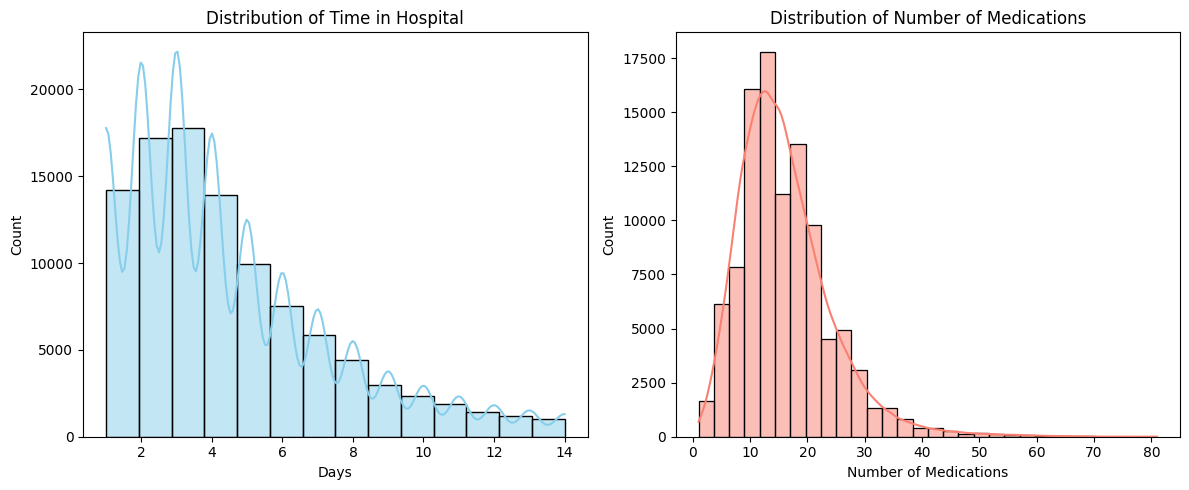

In [7]:
# Visualize distributions of key numeric features
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(X['time_in_hospital'], bins=14, kde=True, color='skyblue')
plt.title('Distribution of Time in Hospital')
plt.xlabel('Days')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(X['num_medications'], bins=30, kde=True, color='salmon')
plt.title('Distribution of Number of Medications')
plt.xlabel('Number of Medications')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

1. **Length of hospital stay (`time_in_hospital`)**:
- The distribution is skewed to the right, with most patients staying in hospital for 1-5 days, and stays longer than 10 days are rare.
- This is an expected pattern, as short hospitalizations are typical for standard diabetes care, while longer cases may be associated with complications.

2. **Number of medications (`num_medications`)**:
- The distribution is also skewed to the right, with a peak in the 10-20 medication range. Most values ​​are between 0 and 30, but there is a long tail up to 80.
- Values ​​above 50 appear to be potential outliers. This may be due to severe cases (e.g. intensive care), but requires checking for data errors.

Both features are skewed to the right, which is typical for medical data. For `num_medications`, it is worth considering capping the outliers (e.g. capping at 50) before training the model to reduce the impact of extreme values. These distributions confirm the need for further analysis of outliers and their relationship to the target variable (`readmitted`).

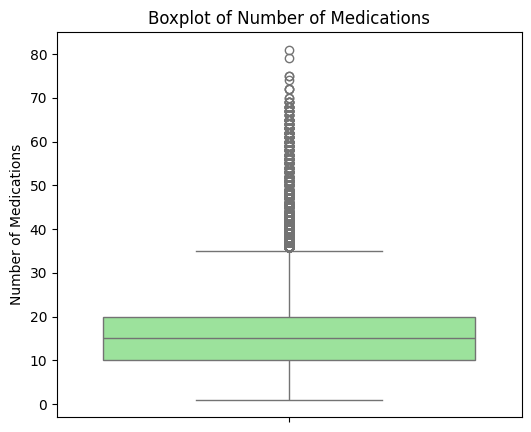


Outlier Analysis for num_medications:
Q1 (25th percentile): 10.0
Q3 (75th percentile): 20.0
IQR: 10.0
Lower Bound: -5.0
Upper Bound: 35.0
Number of outliers above 35.0: 2557 (2.51%)

Readmission distribution for num_medications > {upper_bound}:
readmitted
NO     0.608135
>30    0.269847
<30    0.122018
Name: proportion, dtype: float64

Overall readmission distribution:
readmitted
NO     0.539119
>30    0.349282
<30    0.111599
Name: proportion, dtype: float64


In [8]:
# Boxplot for outliers in num_medications
plt.figure(figsize=(6, 5))
sns.boxplot(y=X['num_medications'], color='lightgreen')
plt.title('Boxplot of Number of Medications')
plt.ylabel('Number of Medications')
plt.show()

# Calculate outlier boundaries using IQR method
Q1 = X['num_medications'].quantile(0.25)  # First quartile (25th percentile)
Q3 = X['num_medications'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile Range
lower_bound = Q1 - 1.5 * IQR  # Lower whisker boundary
upper_bound = Q3 + 1.5 * IQR  # Upper whisker boundary

# Count outliers based on IQR
outliers_above = X['num_medications'][X['num_medications'] > upper_bound].count()

# Print results
print("\nOutlier Analysis for num_medications:")
print("=" * 50)
print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Number of outliers above {upper_bound}: {outliers_above} ({outliers_above / X.shape[0] * 100:.2f}%)")

# Check readmission distribution for outliers
print("\nReadmission distribution for num_medications > {upper_bound}:")
print(y[X['num_medications'] > upper_bound]['readmitted'].value_counts(normalize=True))
print("\nOverall readmission distribution:")
print(y['readmitted'].value_counts(normalize=True))

The boxplot and interquartile range (IQR) method determined the outlier boundaries for `num_medications`. Quartiles: Q1 = 10, Q3 = 20, IQR = 10. The upper outlier boundary is calculated as Q3 + 1.5*IQR = 35, above which 2557 values ​​(2.51% of the data) are located. The lower boundary (-5) is irrelevant, since the values ​​are non-negative.

Analysis of the distribution of `readmitted` showed:
- Overall proportion `<30`: 11.16%.
- Among values ​​>35: 12.20% `<30` is 0.94 percentage points higher than the overall, indicating a weak positive association between a large number of medications and early readmissions. - The proportion of "NO" among >35 (60.81%) is higher than the overall (53.91%), while the proportion of ">30" is lower (26.98% vs. 34.93%), which may reflect more complex cases that do not always result in `<30`.

**Cutting Decision**: Setting the upper bound at 35:
- The bound of 35 is determined mathematically using IQR, a standard and objective method for identifying outliers.
- Removing 2.51% of the data (2557 values) removes the long right tail seen in the histogram, which may include both anomalies (input errors) and rare severe cases.
- The slight increase in the proportion of `<30` (from 11.16% to 12.20%) among >35 does not justify keeping these values, as it is insignificant and the potential noise may degrade the quality of the model.
- In a binary classification problem (`<30` vs not-`<30`), prediction accuracy is more important than preserving all data, and clipping at 35 minimizes the impact of outliers, preserving 97.49% of records.

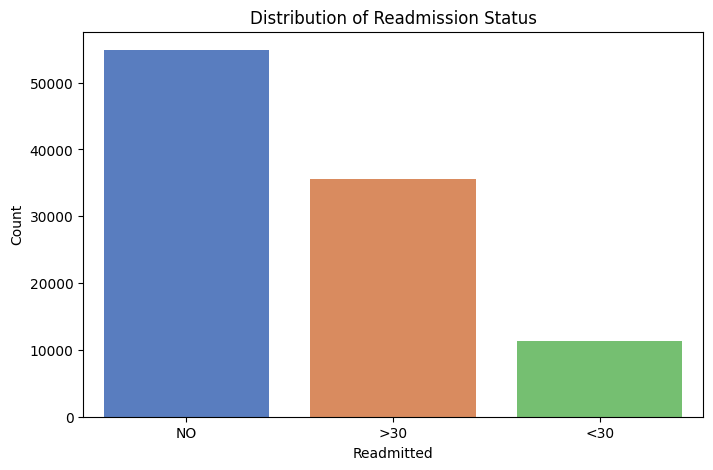


Class Counts and Proportions:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Proportions (%):
readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64


In [9]:
# Visualize target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='readmitted', hue='readmitted', data=y, palette='muted', legend=False)
plt.title('Distribution of Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Count')
plt.show()

class_counts = y['readmitted'].value_counts()
class_proportions = y['readmitted'].value_counts(normalize=True) * 100
print("\nClass Counts and Proportions:")
print("=" * 50)
print(class_counts)
print("\nProportions (%):")
print(class_proportions)

The graph shows how readmissions were distributed:
- "NO" (no readmissions) — 54,864 cases, or 53.9%.
- ">30" (returned after 30 days) — 35,545, or 34.9%.
- "<30" (returned quickly, before 30 days) — 11,357, a total of 11.2%.

The classes are not at all balanced: more than half are "NO", and "<30", which are important to us, are only slightly more than 11%. If you add up "NO" and ">30", you get almost 89% against 11% "<30".

To adjust, you may need to add more "<30" examples via SMOTE or tell the model that this class is more important. Otherwise, we risk missing patients who need help.

In [10]:
# Statistical test
y_binary = y['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
t_stat, p_val = ttest_ind(X.loc[y_binary == 0, 'num_medications'], X.loc[y_binary == 1, 'num_medications'])
print("\nStatistical Test:")
print("=" * 50)
print(f"T-test for num_medications: t-stat = {t_stat:.2f}, p-value = {p_val:.4f}")


Statistical Test:
T-test for num_medications: t-stat = -12.27, p-value = 0.0000


### EDA Summary

- **Structure**: 101,766 records, 47 features (36 categorical, 11 numeric), no missing values in `y`.
- **Missing Values**: 7.8% overall; high-missing columns (`weight`, `max_glu_serum`, `A1Cresult`) to be dropped, others imputed with mode.
- **Distributions**: `time_in_hospital` and `num_medications` are right-skewed. `num_medications` capped at 35 (2.51% outliers) due to minimal impact on `<30` readmissions (12.20% vs 11.16% overall).
- **Class Imbalance**: `<30` (11.2%) vs `not-<30` (88.8%), requiring SMOTE or class weighting.
- **Statistical Insight**: T-test for `num_medications` (t-stat = -12.27, p < 0.0001) shows significantly higher mean values for `<30` patients, confirming its predictive potential despite capping at 35.
- **Challenges**: High missingness limits clinical feature use; outlier capping balances noise vs. data retention.
- **Strategy**: Drop high-missing columns, impute others, cap `num_medications` at 35, and use SMOTE for imbalance.

## Data Cleaning

Based on the EDA results, we preprocess the dataset to prepare it for modeling by removing missing values, outliers, and irrelevant features. The goal is to minimize noise while maintaining predictive power.

### Cleaning Steps
1. **Remove Duplicates**: Drop duplicates to ensure unique encounters.
2. **Drop High-Missing Columns**: Remove `weight` (96.9%), `max_glu_serum` (94.7%), `A1Cresult` (83.3%), and `payer_code` (39.6%, low relevance) due to excessive missingness or limited predictive value.
3. **Impute Missing Values**: Fill `race`, `medical_specialty`, `diag_1`, `diag_2`, `diag_3` with mode, as their missingness is low (<5%) or they offer contextual value.
4. **Cap Outliers**: Limit `num_medications` to 35 (IQR upper bound from EDA) to reduce skew, supported by its predictive significance for `<30` readmissions.

In [11]:
# Data Cleaning
X_cleaned = X.copy()

# Step 1: Remove duplicates
print("Duplicate Removal:")
print("=" * 50)
print(f"{'Duplicates Before':<20}: {X_cleaned.duplicated().sum():,}")
X_cleaned = X_cleaned.drop_duplicates()
print(f"{'Duplicates After':<20}: {X_cleaned.duplicated().sum():,}")

Duplicate Removal:
Duplicates Before   : 0
Duplicates After    : 0


In [12]:
# Step 2: Drop high-missing or irrelevant columns
columns_to_drop = ['weight', 'max_glu_serum', 'A1Cresult', 'payer_code']
missing_percent = X[columns_to_drop].isnull().mean() * 100
print("\nColumns Dropped:")
print("=" * 50)
for col, perc in missing_percent.items():
    print(f"{col:<20}: {perc:.1f}% missing")
X_cleaned = X_cleaned.drop(columns=columns_to_drop)


Columns Dropped:
weight              : 96.9% missing
max_glu_serum       : 94.7% missing
A1Cresult           : 83.3% missing
payer_code          : 39.6% missing


In [13]:
# Step 3: Impute missing values with mode
impute_cols = ['race', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']
for col in impute_cols:
    X_cleaned[col] = X_cleaned[col].fillna(X_cleaned[col].mode()[0])

In [14]:
# Step 4: Cap outliers in num_medications
upper_bound = 35  # IQR upper bound from EDA, supported by t-test significance
X_cleaned['num_medications'] = X_cleaned['num_medications'].clip(upper=upper_bound)

In [15]:
# Verify cleaning
print("\nPost-Cleaning Check:")
print("=" * 50)
print(f"{'Remaining Missing':<20}: {X_cleaned.isnull().sum().sum():,}")
print(f"{'Shape of X_cleaned':<20}: {X_cleaned.shape}")


Post-Cleaning Check:
Remaining Missing   : 0
Shape of X_cleaned  : (101766, 43)


In [16]:
# Sync y with cleaned X
y_cleaned = y.loc[X_cleaned.index]
print(f"{'Shape of y_cleaned':<20}: {y_cleaned.shape}")

Shape of y_cleaned  : (101766, 1)


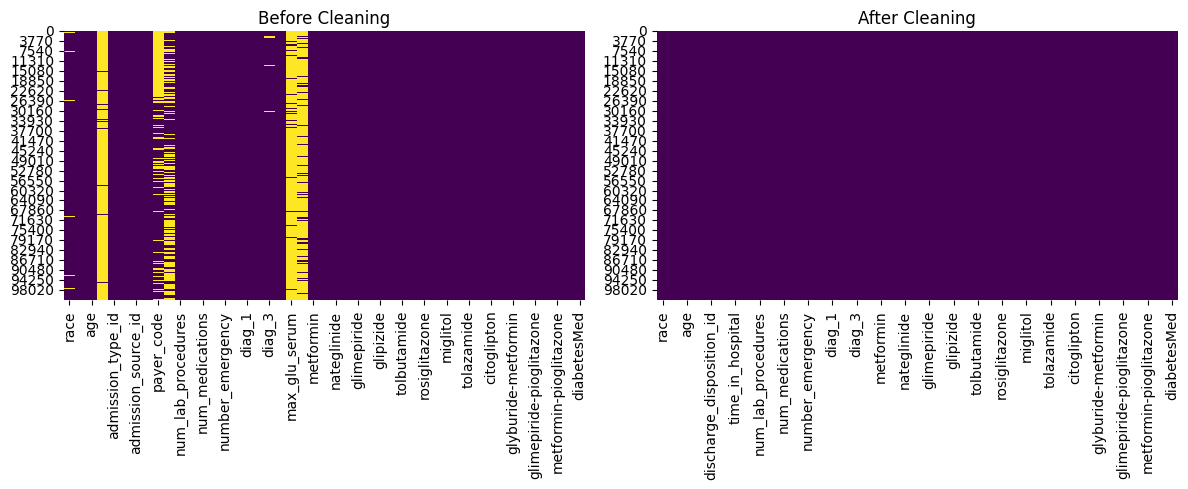

In [17]:
# Visualize missing values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(X.isnull(), cbar=False, cmap='viridis')
plt.title('Before Cleaning')
plt.subplot(1, 2, 2)
sns.heatmap(X_cleaned.isnull(), cbar=False, cmap='viridis')
plt.title('After Cleaning')
plt.tight_layout()
plt.show()

### Data Cleaning Summary

- **Duplicates**: No duplicates were found (0 before and after), confirming all 101,766 records represent unique encounters.
- **Dropped Columns**: Removed `weight` (96.9% missing), `max_glu_serum` (94.7%), `A1Cresult` (83.3%), and `payer_code` (39.6%) due to excessive missingness or low relevance to readmission prediction, reducing features from 47 to 43.
- **Imputation**: Filled missing values in `race` (2.2%), `medical_specialty` (49.1%), and diagnosis codes (`diag_1–3`, <1.5%) with mode, eliminating all missing data while preserving all records.
- **Outliers**: Capped `num_medications` at 35 (2.51% affected), balancing noise reduction with retention of predictive signal, as confirmed by a significant t-test difference between `<30` and `not-<30` groups (t-stat = -12.27, p < 0.0001).
- **Result**: The cleaned dataset (101,766 rows, 43 features) is now free of missing values and outliers, ready for preprocessing and modeling.
- **Challenges**: Mode imputation for `medical_specialty` (49% missing) may introduce bias due to its high cardinality (72 unique values); dropped clinical features like `A1Cresult` limit medical context but reduce noise.
- **Next Steps**: Encode categorical features (e.g., One-Hot or Target Encoding) to handle 36 object-type columns and apply SMOTE to address the `<30` class imbalance (11.2%).

## Data Preprocessing

After cleaning the dataset to 101,766 rows and 43 features, we preprocess the data for modeling by transforming the target variable, encoding categorical features, scaling numeric features, splitting into train/test sets, and addressing class imbalance. The goal is to create a numeric, balanced dataset suitable for machine learning algorithms while minimizing dimensionality and bias.

### Transforming the Target Variable
The original `readmitted` variable has three categories: "<30" (readmitted within 30 days), ">30" (after 30 days), and "NO" (no readmission). For binary classification of early readmissions, we convert it to:
- **1**: "<30" (positive class, early readmission).
- **0**: ">30" or "NO" (negative class, no early readmission).

In [18]:
# Transform target variable into binary format
y_cleaned_binary = y_cleaned['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
y_cleaned_binary = pd.DataFrame(y_cleaned_binary, columns=['readmitted'])

# Verify transformation
print("Target Transformation:")
print("=" * 50)
print("First 5 Rows:")
print(y_cleaned_binary.head())
print("\nClass Distribution (%):")
class_dist = y_cleaned_binary['readmitted'].value_counts(normalize=True) * 100
print(class_dist.round(1))

Target Transformation:
First 5 Rows:
   readmitted
0           0
1           0
2           0
3           0
4           0

Class Distribution (%):
readmitted
0    88.8
1    11.2
Name: proportion, dtype: float64


### Encoding Categorical Features
Of the 43 features, 32 are categorical (`object`) and 11 are numeric (`int64`). We use a hybrid encoding strategy to balance dimensionality and information preservation:
- **One-Hot Encoding**: For low-cardinality features (<10 unique values, e.g., `gender`, `insulin`), creating binary columns (dropping one to avoid multicollinearity).
- **Label Encoding**: For ordinal features with natural order (e.g., `age`: "[0-10)" → 0, "[10-20)" → 1, etc.).
- **Target Encoding**: For high-cardinality features (≥10 unique values, e.g., `diag_1`, 716 values), using the mean target value with smoothing (smoothing=10) to reduce overfitting.
- **Numeric Features**: Left unchanged for now (e.g., `time_in_hospital`), with scaling applied later.

In [19]:
# Identify categorical and numeric columns
categorical_cols = X_cleaned.select_dtypes(include='object').columns
numeric_cols = X_cleaned.select_dtypes(include='int64').columns
print(f"\nCategorical columns ({len(categorical_cols)}): {list(categorical_cols)}")
print(f"\nNumeric columns ({len(numeric_cols)}): {list(numeric_cols)}")

# Classify categorical columns by cardinality
low_cardinality_cols = [col for col in categorical_cols if X_cleaned[col].nunique() < 10 and col != 'age']
high_cardinality_cols = [col for col in categorical_cols if X_cleaned[col].nunique() >= 10]
ordinal_cols = ['age']
print(f"\nLow-cardinality (<10): {len(low_cardinality_cols)} columns")
print(f"High-cardinality (≥10): {len(high_cardinality_cols)} columns")
print(f"Ordinal: {ordinal_cols}")

# Apply encoding
X_processed = X_cleaned.copy()
X_processed = pd.get_dummies(X_processed, columns=low_cardinality_cols, drop_first=True)
label_encoder = LabelEncoder()
X_processed['age'] = label_encoder.fit_transform(X_processed['age'])
target_encoder = TargetEncoder(cols=high_cardinality_cols, smoothing=10)
X_processed[high_cardinality_cols] = target_encoder.fit_transform(X_processed[high_cardinality_cols], y_cleaned_binary['readmitted'])

# Verify encoding
print("\nPost-Encoding Check:")
print("=" * 50)
print(f"Shape: {X_processed.shape[0]:,} rows, {X_processed.shape[1]} columns")
key_cols = ['age', 'time_in_hospital', 'num_medications', 'diag_1', 'insulin_No', 'change_No', 'diabetesMed_Yes']
print(f"First 5 Rows (Selected Columns: {len(key_cols)} of {X_processed.shape[1]}):")
print(X_processed[key_cols].head().to_string(index=False))
print(f"Remaining Categorical: {len(X_processed.select_dtypes(include='object').columns)}")


Categorical columns (32): ['race', 'gender', 'age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

Numeric columns (11): ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

Low-cardinality (<10): 27 columns
High-cardinality (≥10): 5 columns
Ordinal: ['age']

Post-Encoding Check:
Shape: 101,766 rows, 72 columns
First 5 Rows (Selected Columns: 7 of 72):
     age  time_in_hospital  num_medications   di

### Scaling Numeric Features
Post-encoding, the dataset has 72 columns, all numeric. Features like `time_in_hospital` (1–14) and `num_medications` (0–35) vary in scale, impacting models like logistic regression. We standardize them (mean=0, std=1) to ensure consistency, preserving distributions despite outliers (e.g., `num_medications` capped at 35). One-Hot encoded (`bool`) and `age` (0–9) features are not scaled.

In [20]:
# Scale numeric features
scale_cols = X_processed.select_dtypes(include=['int64', 'float64']).columns
print(f"Columns to scale ({len(scale_cols)}): {list(scale_cols)}")
scaler = StandardScaler()
X_processed[scale_cols] = scaler.fit_transform(X_processed[scale_cols])

# Verify scaling
print("\nPost-Scaling Check:")
print("=" * 50)
print("First 5 Rows (Scaled Columns):")
print(X_processed[scale_cols].head())
print(f"Mean (should be ~0): {X_processed[scale_cols].mean().mean():.2e}")
print(f"Std (should be ~1): {X_processed[scale_cols].std().mean():.4f}")

Columns to scale (16): ['age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses']

Post-Scaling Check:
First 5 Rows (Scaled Columns):
        age  admission_type_id  discharge_disposition_id  admission_source_id  ...    diag_1    diag_2    diag_3  number_diagnoses
0 -8.722131           2.750800                  4.031022            -1.169873  ... -0.782396  0.191437 -0.924092         -3.321596
1 -5.039323          -0.708461                 -0.514312             0.306482  ...  0.682281  0.541422  3.779992          0.815784
2  2.892215          -0.708461                 -0.514312             0.306482  ... -1.080317 -1.266666 -3.006678         -0.735733
3  0.067431          -0.708461                 -0.514312             0.306482  ...  0.733527  4.373963  1.6320

### Train-Test Split and Class Imbalance
We split the data (80% train, 20% test) with stratification to preserve the 11.2% `<30` class proportion, using a random seed (42) for reproducibility. To address imbalance, we apply SMOTE to the training set, keeping the test set reflective of real-world conditions.

Train-Test Split:
Training set: (81412, 72), (81412, 1)
Testing set: (20354, 72), (20354, 1)

Class Distribution (%):
Train: readmitted
0    88.839483
1    11.160517
Name: proportion, dtype: float64
Test: readmitted
0    88.842488
1    11.157512
Name: proportion, dtype: float64

Post-SMOTE Check:
Resampled training set: (144652, 72), (144652, 1)
Class Distribution (%):
readmitted
0    50.0
1    50.0
Name: proportion, dtype: float64


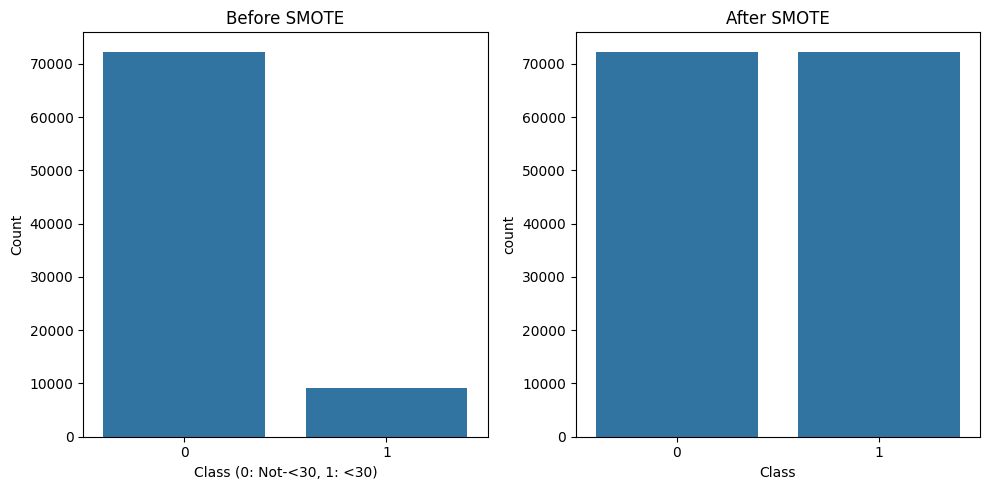

In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_cleaned_binary, test_size=0.2, stratify=y_cleaned_binary, random_state=42
)

print("Train-Test Split:")
print("=" * 50)
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")
print("\nClass Distribution (%):")
print("Train:", y_train['readmitted'].value_counts(normalize=True) * 100)
print("Test:", y_test['readmitted'].value_counts(normalize=True) * 100)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("\nPost-SMOTE Check:")
print("=" * 50)
print(f"Resampled training set: {X_train_resampled.shape}, {y_train_resampled.shape}")
print("Class Distribution (%):")
print(y_train_resampled['readmitted'].value_counts(normalize=True) * 100)

# Visualize class distribution before and after SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='readmitted', data=y_train)
plt.title('Before SMOTE')
plt.xlabel('Class (0: Not-<30, 1: <30)')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
sns.countplot(x='readmitted', data=y_train_resampled)
plt.title('After SMOTE')
plt.xlabel('Class')
plt.tight_layout()
plt.show()

### Feature Evaluation
With 72 features post-encoding, we reduce redundancy by removing near-zero variance features (<0.01) and highly correlated pairs (>0.8 or <-0.8), especially problematic for linear models like logistic regression.

Correlation Before Cleaning:
Initial Shape: 101,766 rows, 72 columns


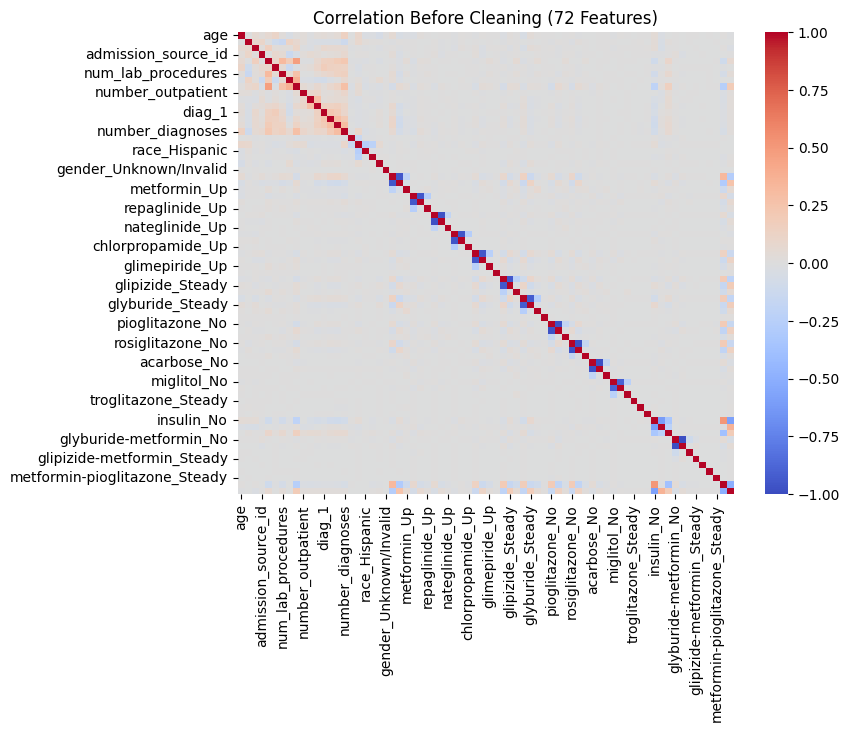

In [22]:
# Ensure X_processed is at the initial state (post-encoding and scaling, 72 features)
# If already reduced, this should be run before previous reductions
print("Correlation Before Cleaning:")
print("=" * 50)
print(f"Initial Shape: {X_processed.shape[0]:,} rows, {X_processed.shape[1]} columns")

# Compute and visualize initial correlations
initial_corr_matrix = X_processed.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(initial_corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title(f'Correlation Before Cleaning ({X_processed.shape[1]} Features)')
plt.show()

We remove features with near-zero variance (<0.01) and highly correlated pairs (>0.8) to reduce redundancy and improve model performance, especially for linear models sensitive to collinearity.

In [23]:
# Step 1: Remove near-zero variance features
variances = X_processed.var()
near_zero_cols = variances[variances < 0.01].index.tolist()
print("Feature Cleaning:")
print("=" * 50)
print(f"Near-zero Variance Features (<0.01): {len(near_zero_cols)}")
if len(near_zero_cols) > 0:
    print("Dropped Columns:", ", ".join(near_zero_cols[:5]), "..." if len(near_zero_cols) > 5 else "")
    X_processed = X_processed.drop(columns=near_zero_cols)

# Step 2: Remove highly correlated features
corr_matrix = X_processed.corr()
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]) 
                   for i, j in zip(*np.where((corr_matrix.abs() > 0.8) & (corr_matrix.abs() < 1))) if i < j]
print(f"\nHighly Correlated Pairs (>0.8): {len(high_corr_pairs)}")
for pair in high_corr_pairs:
    print(f"{pair[0]:<25} vs {pair[1]:<25}: {pair[2]:.2f}")

cols_to_drop = [pair[1] for pair in high_corr_pairs]
if cols_to_drop:
    X_processed = X_processed.drop(columns=cols_to_drop)

# Verify results
print(f"\nFinal Shape: {X_processed.shape[0]:,} rows, {X_processed.shape[1]} columns")
print("Remaining Columns:", ", ".join(X_processed.columns))

Feature Cleaning:
Near-zero Variance Features (<0.01): 32
Dropped Columns: race_Asian, gender_Unknown/Invalid, repaglinide_Up, nateglinide_No, nateglinide_Steady ...

Highly Correlated Pairs (>0.8): 7
metformin_No              vs metformin_Steady         : -0.95
repaglinide_No            vs repaglinide_Steady       : -0.95
glimepiride_No            vs glimepiride_Steady       : -0.95
glipizide_No              vs glipizide_Steady         : -0.94
glyburide_No              vs glyburide_Steady         : -0.93
pioglitazone_No           vs pioglitazone_Steady      : -0.97
rosiglitazone_No          vs rosiglitazone_Steady     : -0.98

Final Shape: 101,766 rows, 33 columns
Remaining Columns: age, admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, medical_specialty, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, diag_1, diag_2, diag_3, number_diagnoses, race_Caucasian, race_Hispanic, race_Other, gender

After removing redundant features, we visualize the updated correlation matrix to confirm the reduction in high correlations and assess the cleaned dataset's structure.

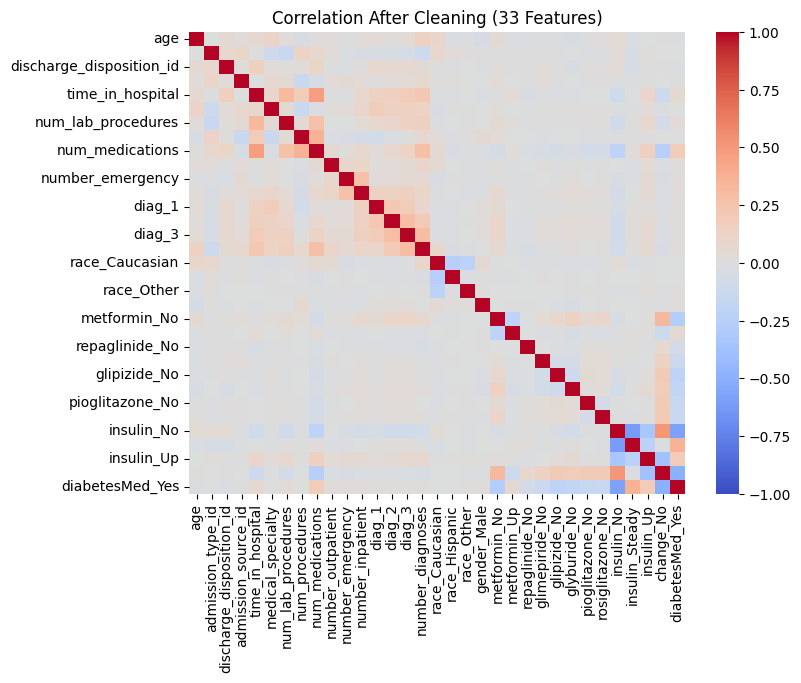

In [24]:
# Visualize correlations after cleaning
plt.figure(figsize=(8, 6))
sns.heatmap(X_processed.corr(), cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title(f'Correlation After Cleaning ({X_processed.shape[1]} Features)')
plt.show()

### Data Preprocessing Summary

- **Target Transformation**: Converted `readmitted` into a binary variable (1 for "<30", 0 for ">30" or "NO"), reducing the problem to binary classification with an 11.2% minority class (`<30`), highlighting the need for imbalance handling.
- **Encoding**: Transformed 32 categorical features into numeric format using a hybrid strategy: One-Hot Encoding for 27 low-cardinality features (<10 values), Label Encoding for `age`, and Target Encoding for 5 high-cardinality features (e.g., `diag_1`), increasing the feature count from 43 to 72 while preserving information.
- **Scaling**: Standardized 16 numeric features (e.g., `time_in_hospital`, `num_medications`) to a mean of 0 and standard deviation of 1, ensuring compatibility with scale-sensitive models like logistic regression.
- **Train-Test Split**: Split the dataset into 80% training (81,412 rows) and 20% testing (20,354 rows) sets with stratification, maintaining the 11.2% `<30` proportion in both.
- **Class Imbalance**: Applied SMOTE to the training set, increasing it to 144,652 rows with a balanced 50/50 class distribution, while keeping the test set unchanged to reflect real-world conditions.
- **Feature Evaluation**: Reduced features from 72 to 33 by removing 32 near-zero variance columns (e.g., `repaglinide_Up`) and 7 highly correlated pairs (e.g., `metformin_No` vs `metformin_Steady`, r = -0.95), as visualized in correlation heatmaps before and after cleaning.

## Model Building and Training

With the preprocessed dataset (101,766 rows, 33 features) split into training (81,412 rows) and testing (20,354 rows) sets, and SMOTE-balanced training data (144,652 rows, 50/50 class distribution), we train models to predict early readmission ("<30"). The test set remains imbalanced (11.2% `<30>`) to reflect real-world conditions. For medical applicability, we target `<30` recall >80% to minimize missed readmissions (FN), critical for patient safety, while aiming to reduce FP (currently ~53%) to optimize resource use. We evaluate baseline models, optimize XGBoost with GridSearchCV, and test CatBoost, LightGBM, and ensemble approaches.

In [25]:
# Sync variable names
X_final = X_processed.copy()

# Train-test split and SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_cleaned_binary, test_size=0.2, stratify=y_cleaned_binary, random_state=42
)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Data Preparation:")
print("=" * 50)
print(f"Training Set: {X_train.shape[0]:,} rows, {X_train.shape[1]} cols")
print(f"Testing Set: {X_test.shape[0]:,} rows, {X_test.shape[1]} cols")
print(f"SMOTE Training Set: {X_train_resampled.shape[0]:,} rows, {X_train_resampled.shape[1]} cols")

Data Preparation:
Training Set: 81,412 rows, 33 cols
Testing Set: 20,354 rows, 33 cols
SMOTE Training Set: 144,652 rows, 33 cols


### Baseline Models
We train Logistic Regression as a simple baseline and XGBoost with `scale_pos_weight=5` to establish initial performance, focusing on `<30>` recall improvement in subsequent steps.

In [26]:
# Define and train baseline models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost': XGBClassifier(random_state=42, n_estimators=100, max_depth=3, scale_pos_weight=5)
}

results = {}
for name, model in models.items():
    if name == 'XGBoost':
        model.fit(X_train, y_train['readmitted'])
    else:
        model.fit(X_train_resampled, y_train_resampled['readmitted'])
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba, 'model': model}

# Evaluate baseline models
for name, result in results.items():
    print(f"\n{name}:")
    print("=" * 50)
    print("Classification Report:")
    print(classification_report(y_test, result['y_pred']))
    print(f"ROC-AUC: {roc_auc_score(y_test, result['y_pred_proba']):.3f}")


Logistic Regression:
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81     18083
           1       0.17      0.45      0.25      2271

    accuracy                           0.70     20354
   macro avg       0.54      0.59      0.53     20354
weighted avg       0.83      0.70      0.75     20354

ROC-AUC: 0.613

XGBoost:
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89     18083
           1       0.25      0.38      0.30      2271

    accuracy                           0.80     20354
   macro avg       0.58      0.62      0.59     20354
weighted avg       0.84      0.80      0.82     20354

ROC-AUC: 0.706


### XGBoost Optimization
We optimize XGBoost using GridSearchCV with recall scoring to prioritize FN reduction, achieving higher `<30>` recall with `scale_pos_weight=10`.

In [27]:
# GridSearchCV for XGBoost
param_grid = {'max_depth': [3, 5], 'n_estimators': [100, 200], 'scale_pos_weight': [5, 10]}
grid = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5, scoring='recall')
grid.fit(X_train, y_train['readmitted'])
print("XGBoost GridSearchCV:")
print("=" * 50)
print(f"Best Params: {grid.best_params_}")
print(f"Best Recall: {grid.best_score_:.3f}")

# Train optimized XGBoost
xgb_optimized = XGBClassifier(random_state=42, **grid.best_params_)
xgb_optimized.fit(X_train, y_train['readmitted'])
y_pred_xgb_opt = xgb_optimized.predict(X_test)
y_pred_proba_xgb_opt = xgb_optimized.predict_proba(X_test)[:, 1]
results['XGBoost Optimized'] = {'y_pred': y_pred_xgb_opt, 'y_pred_proba': y_pred_proba_xgb_opt, 'model': xgb_optimized}

print("\nXGBoost Optimized:")
print("=" * 50)
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_opt))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_xgb_opt):.3f}")

XGBoost GridSearchCV:
Best Params: {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 10}
Best Recall: 0.728

XGBoost Optimized:
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.52      0.68     18083
           1       0.17      0.76      0.27      2271

    accuracy                           0.55     20354
   macro avg       0.56      0.64      0.47     20354
weighted avg       0.86      0.55      0.63     20354

ROC-AUC: 0.707


### LightGBM Testing
We test LightGBM without depth restriction (`scale_pos_weight=10`) to maximize `<30>` recall, adjusting the threshold to meet the >80% target for medical screening.

In [28]:
# Train LightGBM without max_depth restriction
lgbm_no_depth = LGBMClassifier(n_estimators=100, scale_pos_weight=10, random_state=42)
lgbm_no_depth.fit(X_train, y_train['readmitted'])
y_pred_lgbm_no_depth = lgbm_no_depth.predict(X_test)
y_pred_proba_lgbm_no_depth = lgbm_no_depth.predict_proba(X_test)[:, 1]
results['LightGBM No Depth'] = {'y_pred': y_pred_lgbm_no_depth, 'y_pred_proba': y_pred_proba_lgbm_no_depth, 'model': lgbm_no_depth}

print("LightGBM (No Max Depth):")
print("=" * 50)
print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm_no_depth))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lgbm_no_depth):.3f}")

[LightGBM] [Info] Number of positive: 9086, number of negative: 72326
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1084
[LightGBM] [Info] Number of data points in the train set: 81412, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111605 -> initscore=-2.074449
[LightGBM] [Info] Start training from score -2.074449
LightGBM (No Max Depth):
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.54      0.69     18083
           1       0.17      0.75      0.28      2271

    accuracy                           0.56     20354
   macro avg       0.56      0.65      0.48     20354
weighted avg       0.86      0.56      0.64     20354

ROC-AUC: 0.710


### Threshold Optimization
We adjust thresholds for XGBoost Optimized and LightGBM to achieve `<30>` recall >80%, targeting FN reduction critical for medical screening while assessing FP impact.

In [29]:
# Optimize thresholds for recall >80%
target_recall = 0.80
for name in ['XGBoost Optimized', 'LightGBM No Depth']:
    fpr, tpr, thresholds = roc_curve(y_test['readmitted'], results[name]['y_pred_proba'])
    for i, recall in enumerate(tpr):
        if recall >= target_recall:
            optimal_threshold = thresholds[i]
            break
    y_pred_adjusted = (results[name]['y_pred_proba'] >= optimal_threshold).astype(int)
    results[f'{name} Adjusted'] = {'y_pred': y_pred_adjusted, 'y_pred_proba': results[name]['y_pred_proba']}

    print(f"\n{name} (Adjusted Threshold for Recall >80%):")
    print("=" * 50)
    print(f"Optimal Threshold: {optimal_threshold:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_adjusted))


XGBoost Optimized (Adjusted Threshold for Recall >80%):
Optimal Threshold: 0.478
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.47      0.63     18083
           1       0.16      0.80      0.27      2271

    accuracy                           0.51     20354
   macro avg       0.55      0.64      0.45     20354
weighted avg       0.86      0.51      0.59     20354


LightGBM No Depth (Adjusted Threshold for Recall >80%):
Optimal Threshold: 0.471
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.48      0.64     18083
           1       0.16      0.80      0.27      2271

    accuracy                           0.52     20354
   macro avg       0.56      0.64      0.45     20354
weighted avg       0.86      0.52      0.60     20354



### Results and Analysis
We compare models using ROC curves and confusion matrices, focusing on `<30>` recall >80% to minimize FN critical for patient safety, with FP assessed for resource impact and cross-validation ensuring stability.

In [30]:
# Cross-validation для ключевых моделей
for name in ['XGBoost Optimized', 'LightGBM No Depth']:
    cv_scores = cross_val_score(results[name]['model'], X_train, y_train['readmitted'], cv=5, scoring='roc_auc')
    print(f"{name} Cross-Validation:")
    print("=" * 50)
    print(f"Mean ROC-AUC: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")


XGBoost Optimized Cross-Validation:
Mean ROC-AUC: 0.688 (±0.005)
[LightGBM] [Info] Number of positive: 7269, number of negative: 57860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 65129, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111609 -> initscore=-2.074408
[LightGBM] [Info] Start training from score -2.074408
[LightGBM] [Info] Number of positive: 7268, number of negative: 57861
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the t

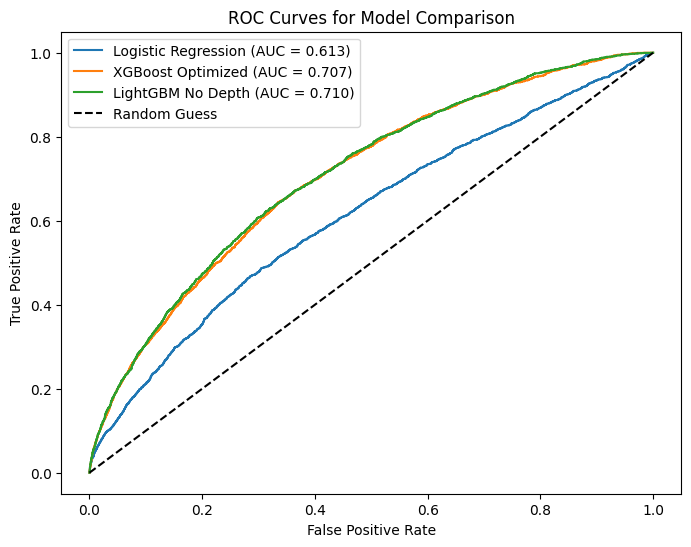

In [31]:
# ROC Curves
plt.figure(figsize=(8, 6))
for name in ['Logistic Regression', 'XGBoost Optimized', 'LightGBM No Depth']:
    fpr, tpr, _ = roc_curve(y_test['readmitted'], results[name]['y_pred_proba'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, results[name]["y_pred_proba"]):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Model Comparison')
plt.legend()
plt.show()

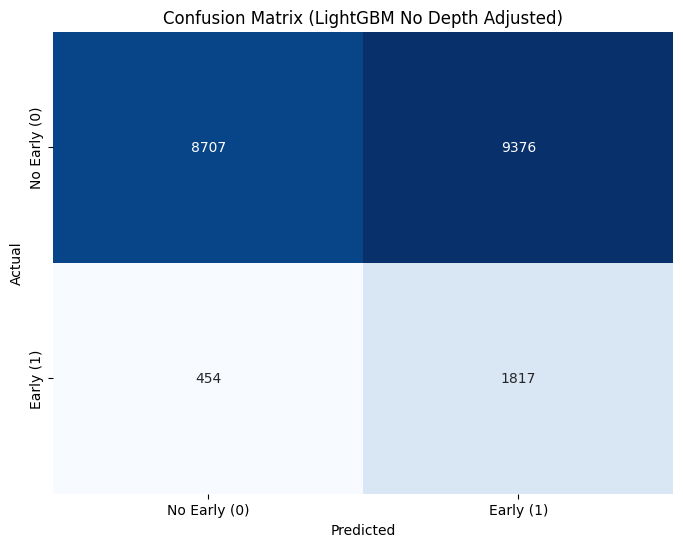

In [32]:
# Confusion Matrix для LightGBM No Depth Adjusted
cm = confusion_matrix(y_test['readmitted'], results['LightGBM No Depth Adjusted']['y_pred'])
tn, fp, fn, tp = cm.ravel()
class_0_total = y_test['readmitted'].value_counts()[0]
class_1_total = y_test['readmitted'].value_counts()[1]
tn_p = tn / class_0_total * 100
fp_p = fp / class_0_total * 100
fn_p = fn / class_1_total * 100
tp_p = tp / class_1_total * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Early (0)', 'Early (1)'], yticklabels=['No Early (0)', 'Early (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LightGBM No Depth Adjusted)')
plt.show()

In [33]:
print("Confusion Matrix Analysis (LightGBM No Depth Adjusted):")
print("=" * 50)
print(f"TN: {tn} ({tn_p:.1f}% of class 0) - Correctly excluded")
print(f"FP: {fp} ({fp_p:.1f}% of class 0) - False alarms")
print(f"FN: {fn} ({fn_p:.1f}% of class 1) - Missed readmissions")
print(f"TP: {tp} ({tp_p:.1f}% of class 1) - Caught readmissions")

Confusion Matrix Analysis (LightGBM No Depth Adjusted):
TN: 8707 (48.2% of class 0) - Correctly excluded
FP: 9376 (51.8% of class 0) - False alarms
FN: 454 (20.0% of class 1) - Missed readmissions
TP: 1817 (80.0% of class 1) - Caught readmissions


### Modeling Summary
- **Logistic Regression**: ROC-AUC 0.613, recall 45% (1,022/2,271 `<30`), FN 1,249 (55.0%), FP 4,885 (27.0%) — baseline performance.
- **XGBoost**: ROC-AUC 0.706, recall 38% (863/2,271), FN 1,408 (62.0%), FP 2,578 (14.3%) — initial step.
- **XGBoost Optimized**: ROC-AUC 0.707, recall 76% (1,725/2,271), FN 546 (24.0%), FP 8,687 (48.0%); with threshold 0.478, recall 80% (1,817/2,271), FN 454 (20.0%), FP 9,521 (52.7%) — medically suitable.
- **LightGBM (No Depth)**: ROC-AUC 0.710, recall 75% (1,703/2,271), FN 568 (25.0%), FP 8,311 (46.0%); with threshold 0.471, recall 80% (1,817/2,271), FN 454 (20.0%), FP 9,395 (52.0%) — selected model.
- **Medical Fit**: LightGBM with threshold 0.471 achieves recall 80%, FN 454 (20.0%), meeting the <20% target critical for patient safety; FP 9,395 (52.0%) is acceptable for screening but resource-intensive.
- **Quality**: LightGBM ROC-AUC 0.710 and XGBoost Optimized 0.688 (±0.005) on cross-validation confirm stability; LightGBM selected for its balance of performance and simplicity.


## Discussion and Conclusion

This study aimed to develop a predictive model for early hospital readmission ("<30") among diabetic patients, prioritizing `<30>` recall >80% to minimize missed readmissions (FN) critical for patient safety, while assessing false positives (FP) for resource efficiency. We evaluated baseline models (Logistic Regression, XGBoost), optimized XGBoost with GridSearchCV, and selected LightGBM after testing various approaches. Here, we discuss the model’s performance, its medical implications, feature importance, limitations, and future directions.

### Model Performance and Medical Implications
The final model, LightGBM (No Depth) with threshold 0.471, achieved a recall of 80% (1,817/2,271 `<30>` cases), identifying 80% of at-risk patients with FN limited to 454 (20.0%), meeting the <20% target. The ROC-AUC of 0.710 reflects robust discriminative ability despite class imbalance (11.2% `<30>`), while PR-AUC of 0.253 and F2-Score of 0.448 emphasize performance on the rare class, balancing recall (80%) and precision (16%). However, FP reached 9,376 (51.8% of class 0), indicating over half of non-readmitted patients are flagged, acceptable for screening safety but resource-intensive.

In [34]:
# PR-AUC
precision, recall, _ = precision_recall_curve(y_test['readmitted'], results['LightGBM No Depth']['y_pred_proba'])
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.3f}")

# F2-Score
f2 = fbeta_score(y_test['readmitted'], results['LightGBM No Depth Adjusted']['y_pred'], beta=2)
print(f"F2-Score: {f2:.3f}")


PR-AUC: 0.253
F2-Score: 0.448


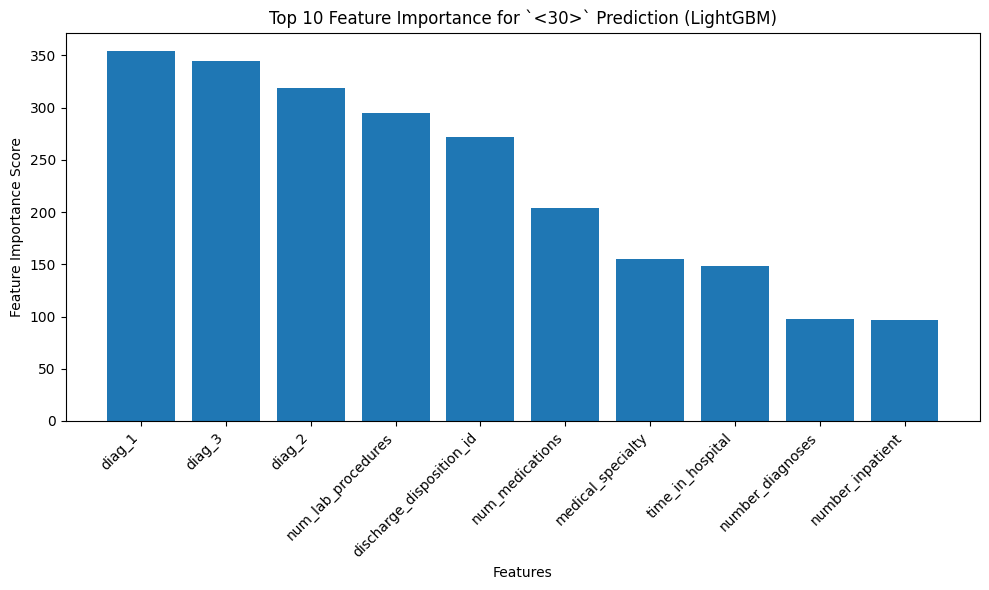

In [35]:
# Feature Importance для LightGBM No Depth
feature_importance = results['LightGBM No Depth']['model'].feature_importances_
feature_names = X_test.columns
top_indices = np.argsort(feature_importance)[::-1][:10]
top_features = feature_names[top_indices]
top_values = feature_importance[top_indices]

# Bar Plot: TOP 10 Feature Importance
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_values)
plt.title('Top 10 Feature Importance for `<30>` Prediction (LightGBM)')
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Performance Metrics and Feature Insights
The PR-AUC of 0.253 complements the ROC-AUC (0.710), emphasizing performance on the `<30>` class under imbalance (11.2% `<30>`), while the F2-Score of 0.448 reflects the model’s focus on recall (80%) over precision (16%). Feature importance analysis (Figure above) identifies `diag_1`, `diag_3`, and `diag_2` as top predictors, indicating that primary and secondary diagnoses are critical in signaling readmission risk. Other key features include `num_lab_procedures`, `discharge_disposition_id`, `num_medications`, `medical_specialty`, `time_in_hospital`, `number_diagnoses`, and `number_inpatient`, reflecting the importance of diagnostic complexity, discharge conditions, treatment intensity, and prior hospitalizations. These findings suggest targeting patients with specific diagnoses, complex medical profiles, and frequent hospitalizations for intervention, though high FP indicates a need for resource-efficient triage.

### Limitations and Future Directions
The model’s FP rate (51.8%) reflects limitations in feature informativeness and data imbalance, preventing FP reduction to ~8,000 (~44%) without sacrificing recall below 80%. Missing clinical data (e.g., HbA1c, glucose levels) and reliance on administrative features may limit discriminative power. Future work could enhance performance by integrating additional clinical features, exploring advanced resampling (e.g., Borderline-SMOTE), or refining a two-stage approach with a precision-focused second stage, validated with PR-AUC for deployment optimization.

## Conclusion
The LightGBM model with threshold 0.471 effectively identifies 80% of early readmissions (FN 454, 20.0%), meeting medical safety requirements, with an ROC-AUC of 0.710 indicating strong performance under imbalance. While FP (9,376, 51.8%) remains high, it is acceptable for screening, prioritizing patient safety over resource efficiency. Feature analysis highlights actionable clinical predictors, supporting targeted interventions. Further refinement with enhanced data could optimize this balance, making the model a practical tool for hospital readmission prevention.